In [1]:
from pyNN.random import RandomDistribution, NumpyRNG
from pyNN import arbor, neuron
import pyNN.space as space
import pyNN
import pyNN.neuron as sim
import numpy as np
from pyNN.utility.plotting import Figure, Panel
from pyNN.space import Grid2D, RandomStructure, Sphere
import matplotlib.pyplot as plt
from neuroml import Morphology, Segment, Point3DWithDiam as P
from pyNN.morphology import NeuroMLMorphology, NeuriteDistribution, Morphology as Morph, IonChannelDistribution
from pyNN.neuron.morphology import uniform, random_section, random_placement, at_distances, apical_dendrites, dendrites
from pyNN.parameters import IonicSpecies
from pyNN.standardmodels import StandardIonChannelModel, build_translations
from pyNN.neuron import NativeCellType
import shutil
import os
from neuron import h, nrn, hclass
from pyNN.utility.build import compile_nmodl
from pyNN.standardmodels.cells import MultiCompartmentNeuron as mc

numprocs=1


In [2]:
shutil.copyfile('mn.mod','modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.mod')
compile_nmodl('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl')
h.nrn_load_dll('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.o')

nrnivmodl found at /media/rnwatanabe/Data/Renato/pyNNstudies/modelpynn/bin/nrnivmodl
Successfully compiled NEURON extensions.


0.0

In [3]:
# input_rate = 100
# refractory_period = RandomDistribution('uniform', [2.0, 3.0], rng=NumpyRNG(seed=4242))
# v_init = RandomDistribution('uniform', (-70.0, -60.0))
# ctx_parameters = {
#     'cm': 0.25, 'tau_m': 20.0, 'v_rest': -60, 'v_thresh': -50, 'tau_refrac': refractory_period,
#     'v_reset': -60, 'v_spike': -50.0, 'a': 1.0, 'b': 0.005, 'tau_w': 600, 'delta_T': 2.5,
#     'tau_syn_E': 5.0, 'e_rev_E': 0.0, 'tau_syn_I': 10.0, 'e_rev_I': -80 }
# cortical_type = sim.EIF_cond_exp_isfa_ista(**ctx_parameters)

In [4]:
class KsChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    translations = build_translations(
        ('conductance_density', 'gk_slow'),
        ('e_rev', 'eks'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'p': ('motoneuron', 'p'),
    }
    default_initial_values = {
        'p': 1,  # initial value for gating variable m
    }
    units = {
        'iks': 'mA/cm2',
        'p': 'dimensionless',
    }
    recordable = ['iks','p']
    model = "motoneuron"
    conductance_density_parameter = 'gk_slow'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [5]:
class KfChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    recordable = ['ikf','n'] 
    translations = build_translations(
        ('conductance_density', 'gk_fast'),
        ('e_rev', 'ekf'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'n': ('motoneuron', 'n'),
    }
    default_initial_values = {
        'n': 1,  # initial value for gating variable m
    }
    units = {
        'ikf': 'mA/cm2',
        'n': 'dimensionless',
    }
    model = "motoneuron"
    conductance_density_parameter = 'gk_fast'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [6]:
class NaChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": 50,
        "vt":-57.65,
    }
    
    default_initial_values = {
        'm': 1.0,  # initial value for gating variable m
        'h': 0.0,  # initial value for gating variable h
    }
    recordable = ['ina', 'm', 'h']
    units = {
        'ina': 'mA/cm2',
        'm': 'dimensionless',
        'h': 'dimensionless',
    }
    translations = build_translations(
        ('conductance_density', 'gna'),
        ('e_rev', 'ena'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'h': ('motoneuron', 'h'),
        'm': ('motoneuron', 'm'),
        'ina': ('motoneuron', 'ina'),
    }
    model = "motoneuron"
    conductance_density_parameter = 'gna'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [7]:
class PassiveLeak(StandardIonChannelModel):
    translations = build_translations(
        ('conductance_density', 'gl'),
        ('e_rev', 'el'),
    )
    variable_translations = {}
    model = "motoneuron"
    conductance_density_parameter = 'gl'

In [8]:
soma1 = Segment(proximal=P(x=77.5, y=0, z=0, diameter=77.5),
               distal=P(x=0, y=0, z=0, diameter=77.5),
               name="soma", id=0)
soma2 = Segment(proximal=P(x=82.5, y=0, z=0, diameter=82.5),
               distal=P(x=0, y=0, z=0, diameter=82.5),
               name="soma", id=0)
dend1 = Segment(proximal=P(x=0, y=0, z=0, diameter=41.5),
               distal=P(x=-5500, y=0, z=0, diameter=41.5),
               name="dendrite",
               parent=soma1, id=1)
dend2 = Segment(proximal=P(x=0, y=0, z=0, diameter=62.5),
               distal=P(x=-6789, y=0, z=0, diameter=62.5),
               name="dendrite",
               parent=soma2, id=1)

class cell_class(sim.MultiCompartmentNeuron):


    def __init__(self, **parameters):

        self.label = "mn1"
        self.ion_channels = {'pas_soma': PassiveLeak, 'pas_dend': sim.PassiveLeak,
                           'na': NaChannel, 'kf': KfChannel, 'ks': KsChannel}
        self.units = {'v':'mV',
                      'gsyn_exc': 'uS',
                      'gsyn_inh': 'uS',
                      'na.m': 'dimensionless', 'na.h': 'dimensionless', 'kf.n': 'dimensionless', 'ks.p': 'dimensionless',
                      'na.ina': 'mA/cm2', 'kf.ikf': 'mA/cm2', 'ks.iks': 'mA/cm2'}
        self.post_synaptic_entities = {'AMPA': sim.CondExpPostSynapticResponse}
        super().__init__(**parameters)
    
   


In [9]:
cell_type = cell_class(
    morphology=[NeuroMLMorphology(Morphology(segments=(soma1, 
                                                       dend1))),
                NeuroMLMorphology(Morphology(segments=(soma2, 
                                                       dend2)))],
    cm=1,    # mF / cm**2
    Ra=70
    ,  # ohm.cm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 30), "vt":[-57.65, -53]},
    kf = {"conductance_density": uniform('soma', 4), "vt":[-57.65, -53]},
    ks = {"conductance_density": uniform('soma', 1), "vt":[-57.65, -53]},

    AMPA={
        "locations": random_placement(uniform('dendrite', 1)),  # number per µm
        "e_syn": 0.0,
        "tau_syn": 0.6
    },  
)

In [10]:
cells = sim.Population(2, cell_type, initial_values={'v': [-70, -70]})

In [11]:
cells[0:1].celltype.parameter_space['morphology'][1].segments[1].surface_area

1333017.032826319

In [12]:
dir(cells[0:1].celltype.post_synaptic_entities)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [13]:
input_rate = 80
number = int(2 * 100 * input_rate / 1000.0)
np.random.seed(26278342)

In [14]:
def generate_spike_times(i):
    gen = lambda: neuron.Sequence(np.add.accumulate(np.random.exponential(1000.0 / input_rate, size=number)))
    if hasattr(i, "__len__"):
        return [gen() for j in i]
    else:
        return gen()
assert generate_spike_times(0).max() > 100

In [15]:
spike_source = sim.Population(400, sim.SpikeSourceArray(spike_times=generate_spike_times))
step_current_dend = sim.DCSource(amplitude=700, start=0, stop=50)
#step_current.inject_into(cells[1:2], location=apical_dendrites(fraction_along=0.9))
#step_current.inject_into(cells[1:2], location=random(after_branch_point(3)(apical_dendrites))
random_location = random_placement(uniform('dendrite', 1))
step_current_dend.inject_into(cells[0:2], location='dendrite')

In [16]:
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')


In [17]:
syn = sim.StaticSynapse(weight=1, delay=0.2)
input_conns = sim.Projection(spike_source, cells[[0]], 
                             sim.FixedProbabilityConnector(0.5), syn, 
                             receptor_type='AMPA')


ConnectionError: User gave receptor_types=dendrite.AMPA, receptor_types must be one of: 'AMPA'

In [ ]:
sim.run(100)

100.00000000001417

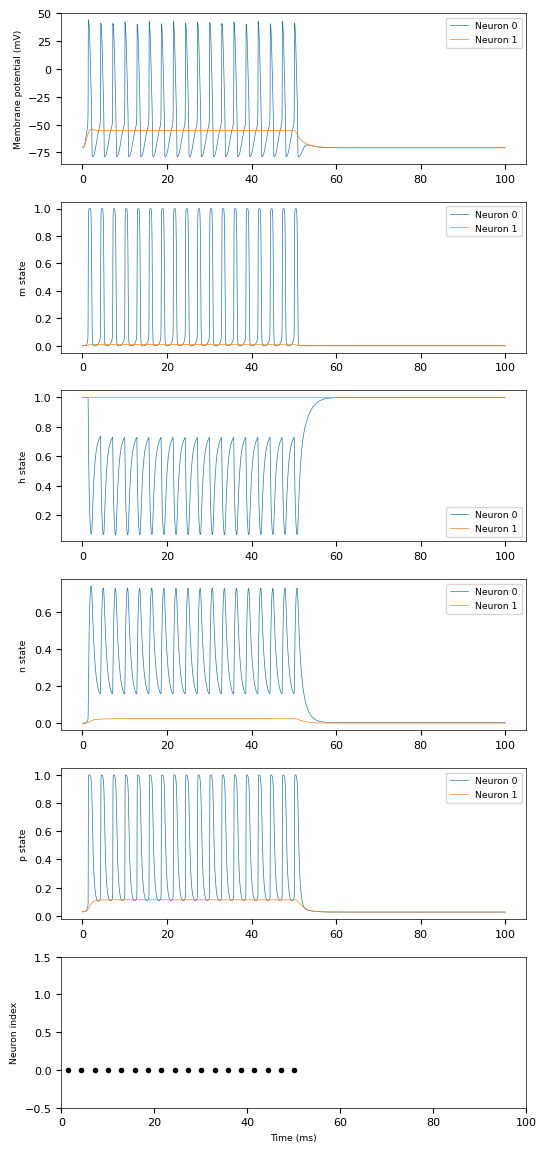

In [ ]:
figure_filename = 'teste.png'

data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),
    
    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)


In [ ]:
data

Segment with [<AnalogSignal(array([[-70.        , -70.        ],
       [-70.09919133, -70.07644188],
       [-70.16347101, -70.12033961],
       ...,
       [-70.86563064, -70.59957732],
       [-70.86563064, -70.59957732],
       [-70.86563064, -70.59957732]]) * mV, [0.0 ms, 100.025 ms], sampling rate: 40.0 1/ms)>, <AnalogSignal(array([[1.        , 1.        ],
       [0.99999724, 0.99999891],
       [0.99999456, 0.99999785],
       ...,
       [0.99986084, 0.99995461],
       [0.99986084, 0.99995461],
       [0.99986084, 0.99995461]]) * dimensionless, [0.0 ms, 100.025 ms], sampling rate: 40.0 1/ms)>, <AnalogSignal(array([[0.        , 0.        ],
       [0.00029447, 0.00010768],
       [0.00049426, 0.00017883],
       ...,
       [0.0008025 , 0.00028911],
       [0.0008025 , 0.00028911],
       [0.0008025 , 0.00028911]]) * dimensionless, [0.0 ms, 100.025 ms], sampling rate: 40.0 1/ms)>, <AnalogSignal(array([[0.00000000e+00, 0.00000000e+00],
       [9.00411431e-05, 4.15454696e-05],
 

In [ ]:
A = 77.5*3.14*77.5+2*3.14*(77.5/2)**2
g = 1/1150
g/A

3.0738158628686215e-08

In [ ]:
1/1000/14.4

6.944444444444444e-05